# EDA stage | Sebislaw

## Libraries

In [1]:
from os.path  import join
import random
import itertools
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

## Data

In [2]:
data_path = '..\\..\\data'

# The Basics ------------------------------------------------------------------------
# Men
MTeams = pd.read_csv(join(data_path, 'MTeams.csv'))
MSeasons = pd.read_csv(join(data_path, 'MSeasons.csv'))
MNCAATourneySeeds = pd.read_csv(join(data_path, 'MNCAATourneySeeds.csv'))
MRegularSeasonCompactResults = pd.read_csv(join(data_path, 'MRegularSeasonCompactResults.csv'))
MNCAATourneyCompactResults = pd.read_csv(join(data_path, 'MNCAATourneyCompactResults.csv'))
# Women
WTeams = pd.read_csv(join(data_path, 'WTeams.csv'))
WSeasons = pd.read_csv(join(data_path, 'WSeasons.csv'))
WNCAATourneySeeds = pd.read_csv(join(data_path, 'WNCAATourneySeeds.csv'))
WRegularSeasonCompactResults = pd.read_csv(join(data_path, 'WRegularSeasonCompactResults.csv'))
WNCAATourneyCompactResults = pd.read_csv(join(data_path, 'WNCAATourneyCompactResults.csv'))
# Other
SampleSubmissionStage1 = pd.read_csv(join(data_path, 'SampleSubmissionStage1.csv'))
SampleSubmissionStage2 = pd.read_csv(join(data_path, 'SampleSubmissionStage2.csv'))
SeedBenchmarkStage1 = pd.read_csv(join(data_path, 'SeedBenchmarkStage1.csv'))

# Team Box Scores ------------------------------------------------------------------------
# Men
MRegularSeasonDetailedResults = pd.read_csv(join(data_path, 'MRegularSeasonDetailedResults.csv'))
MNCAATourneyDetailedResults = pd.read_csv(join(data_path, 'MNCAATourneyDetailedResults.csv'))
# Women
WRegularSeasonDetailedResults = pd.read_csv(join(data_path, 'WRegularSeasonDetailedResults.csv'))
WNCAATourneyDetailedResults = pd.read_csv(join(data_path, 'WNCAATourneyDetailedResults.csv'))

# Geography ------------------------------------------------------------------------
# All
Cities = pd.read_csv(join(data_path, 'Cities.csv'))
Conferences = pd.read_csv(join(data_path, 'Conferences.csv'))
# Men
MGameCities = pd.read_csv(join(data_path, 'MGameCities.csv'))
# Women
WGameCities = pd.read_csv(join(data_path, 'WGameCities.csv'))

# Public Rankings ------------------------------------------------------------------------
# Men
MMasseyOrdinals = pd.read_csv(join(data_path, 'MMasseyOrdinals.csv')) # men only

# Supplements ------------------------------------------------------------------------
# Men
MTeamCoaches = pd.read_csv(join(data_path, 'MTeamCoaches.csv')) # men only
MTeamConferences = pd.read_csv(join(data_path, 'MTeamConferences.csv'))
MConferenceTourneyGames = pd.read_csv(join(data_path, 'MConferenceTourneyGames.csv'))
MSecondaryTourneyTeams = pd.read_csv(join(data_path, 'MSecondaryTourneyTeams.csv'))
MSecondaryTourneyCompactResults = pd.read_csv(join(data_path, 'MSecondaryTourneyCompactResults.csv'))
MTeamSpellings = pd.read_csv(join(data_path, "MTeamSpellings.csv"), encoding='cp1252')
MNCAATourneySlots = pd.read_csv(join(data_path, 'MNCAATourneySlots.csv'))
MNCAATourneySeedRoundSlots = pd.read_csv(join(data_path, 'MNCAATourneySeedRoundSlots.csv')) # men only
# Women
WTeamConferences = pd.read_csv(join(data_path, 'WTeamConferences.csv'))
WConferenceTourneyGames = pd.read_csv(join(data_path, 'WConferenceTourneyGames.csv'))
WSecondaryTourneyTeams = pd.read_csv(join(data_path, 'WSecondaryTourneyTeams.csv'))
WSecondaryTourneyCompactResults = pd.read_csv(join(data_path, 'WSecondaryTourneyCompactResults.csv'))
WTeamSpellings = pd.read_csv(join(data_path, 'WTeamSpellings.csv'), encoding='cp1252')
WNCAATourneySlots = pd.read_csv(join(data_path, 'WNCAATourneySlots.csv'))

## Data visualisation

### How seeds are given

In [4]:
# Merge to get the winning team's seed
merged_results = pd.merge(
    MRegularSeasonCompactResults,
    MNCAATourneySeeds[['Season', 'Seed', 'TeamID']],
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID'],
    how='inner'
).rename(columns={'Seed': 'WTeamSeed'}).drop('TeamID', axis=1)

# Merge to get the losing team's seed
RegularSeasonSeedResults = pd.merge(
    merged_results,
    MNCAATourneySeeds[['Season', 'Seed', 'TeamID']],
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID'],
    how='inner'
).rename(columns={'Seed': 'LTeamSeed'}).drop('TeamID', axis=1)

# Extract numeric seed values
RegularSeasonSeedResults['WTeamSeedRaw'] = RegularSeasonSeedResults['WTeamSeed'].str.extract('(\d+)')[0].astype(int)
RegularSeasonSeedResults['LTeamSeedRaw'] = RegularSeasonSeedResults['LTeamSeed'].str.extract('(\d+)')[0].astype(int)

RegularSeasonSeedResults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WTeamSeed,LTeamSeed,WTeamSeedRaw,LTeamSeedRaw
0,1985,20,1228,81,1328,64,N,0,W03,Y01,3,1
1,1985,33,1228,73,1328,70,H,0,W03,Y01,3,1
2,1985,118,1242,82,1328,76,H,0,Z03,Y01,3,1
3,1985,54,1374,85,1328,76,N,0,W05,Y01,5,1
4,1985,72,1409,104,1328,89,H,0,X06,Y01,6,1


Win counts for seeds (teams made it into the turney) vs other seeded teams in RegularSeason


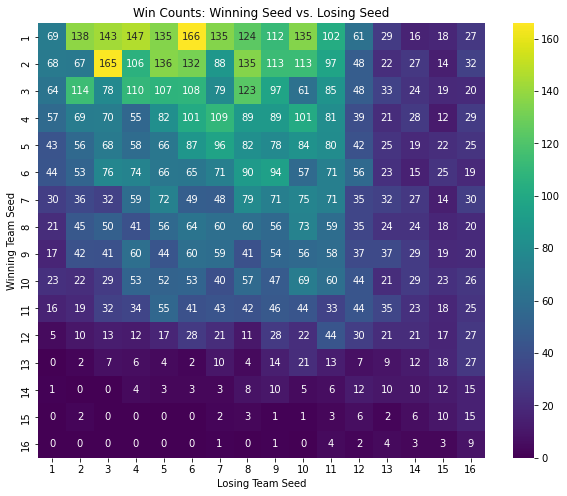

In [5]:
# Create the 16x16 matrix with seed values from 1 to 16
seed_matrix = pd.crosstab(RegularSeasonSeedResults['WTeamSeedRaw'], RegularSeasonSeedResults['LTeamSeedRaw'])
seeds = range(1, 17)
seed_matrix = seed_matrix.reindex(index=seeds, columns=seeds, fill_value=0)

print("Win counts for seeds (teams made it into the turney) vs other seeded teams in RegularSeason")
# If you are in a Jupyter Notebook, simply display the styled DataFrame:

# Plot a heatmap with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(seed_matrix, annot=True, fmt='d', cmap='viridis')
plt.title('Win Counts: Winning Seed vs. Losing Seed')
plt.xlabel('Losing Team Seed')
plt.ylabel('Winning Team Seed')
plt.show()

That means teams who get low number seed and make it into the tournament tend to get matched against teams they won against in the regular season.

Scores from regular season


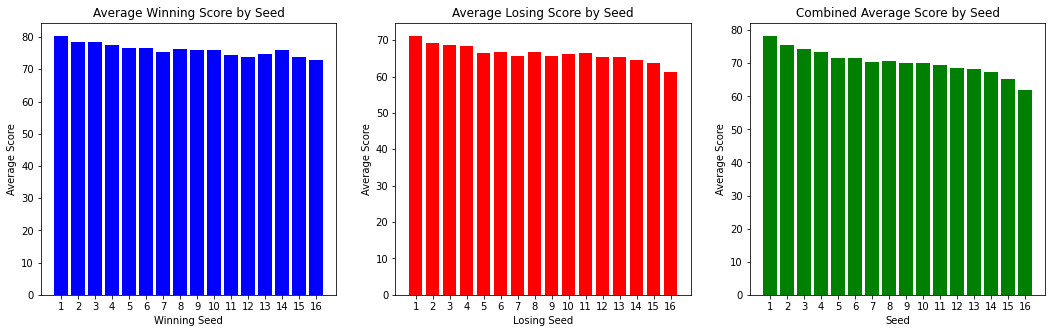

In [6]:
# Compute average score for winning teams grouped by winning seed
avg_win = RegularSeasonSeedResults.groupby('WTeamSeedRaw')['WScore'].mean().sort_index()

# Compute average score for losing teams grouped by losing seed
avg_loss = RegularSeasonSeedResults.groupby('LTeamSeedRaw')['LScore'].mean().sort_index()

# For combined average: combine winning and losing scores into one dataframe.
winning_scores = RegularSeasonSeedResults[['WTeamSeedRaw', 'WScore']].rename(columns={'WTeamSeedRaw':'Seed', 'WScore':'Score'})
losing_scores  = RegularSeasonSeedResults[['LTeamSeedRaw', 'LScore']].rename(columns={'LTeamSeedRaw':'Seed', 'LScore':'Score'})
combined_scores = pd.concat([winning_scores, losing_scores], ignore_index=True)

avg_combined = combined_scores.groupby('Seed')['Score'].mean().sort_index()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Winning seeds only
axes[0].bar(avg_win.index, avg_win.values, color='blue')
axes[0].set_title('Average Winning Score by Seed')
axes[0].set_xlabel('Winning Seed')
axes[0].set_ylabel('Average Score')
axes[0].set_xticks(range(1, 17))

# Plot 2: Losing seeds only
axes[1].bar(avg_loss.index, avg_loss.values, color='red')
axes[1].set_title('Average Losing Score by Seed')
axes[1].set_xlabel('Losing Seed')
axes[1].set_ylabel('Average Score')
axes[1].set_xticks(range(1, 17))

# Plot 3: Combined seeds (winning + losing)
axes[2].bar(avg_combined.index, avg_combined.values, color='green')
axes[2].set_title('Combined Average Score by Seed')
axes[2].set_xlabel('Seed')
axes[2].set_ylabel('Average Score')
axes[2].set_xticks(range(1, 17))

print("Scores from regular season")
plt.show()

On average higher scoring teams in regular season are awarded lower seeds.

### Wchich Teams didn't make it to the tournament?

In [4]:
# Find teams that played in the regular season but didn't make the tournament
regular_season_teams = MRegularSeasonCompactResults[['Season', 'WTeamID']].rename(columns={'WTeamID': 'TeamID'})
regular_season_teams = pd.concat([regular_season_teams,
    MRegularSeasonCompactResults[['Season', 'LTeamID']].rename(columns={'LTeamID': 'TeamID'})],
    ignore_index=True
).drop_duplicates()

# Tournament teams
tourney_teams = MNCAATourneySeeds[['Season', 'TeamID']].drop_duplicates()

# Find teams that are in the regular season but not in the tournament
TeamsInRegularSeasonNotInTourney = regular_season_teams.merge(
    tourney_teams, on=['Season', 'TeamID'], how='left', indicator=True
).query('_merge == "left_only"').drop(columns=['_merge'])

# Create a DataFrame with scores when teams won
win_scores = MRegularSeasonCompactResults[['Season', 'WTeamID', 'WScore']].rename(
    columns={'WTeamID': 'TeamID', 'WScore': 'Score'}
)

# Create a DataFrame with scores when teams lost
loss_scores = MRegularSeasonCompactResults[['Season', 'LTeamID', 'LScore']].rename(
    columns={'LTeamID': 'TeamID', 'LScore': 'Score'}
)

# Concatenate the two DataFrames to have one row per team per game
all_scores = pd.concat([win_scores, loss_scores], ignore_index=True)

# Group by Season and TeamID to calculate the total score for each team per season
total_scores = all_scores.groupby(['Season', 'TeamID'])['Score'].sum().reset_index()
mean_scores = all_scores.groupby(['Season', 'TeamID'])['Score'].mean().reset_index()
score_stats = pd.merge(total_scores, mean_scores, on=['Season', 'TeamID'], suffixes=('', '_Mean'))

# Filter for teams that are in TeamsInRegularSeasonNotInTourney
TeamsInRegularSeasonNotInTourney_totals = pd.merge(
    TeamsInRegularSeasonNotInTourney,
    score_stats,
    on=['Season', 'TeamID'],
    how='left'
)

year = 2010
print('For year ', year)
# In case a team has no score (shouldn't happen if they played), fill with 0
TeamsInRegularSeasonNotInTourney_totals['Score'] = TeamsInRegularSeasonNotInTourney_totals['Score'].fillna(0)
print('Max score of team, that did not make it into tourney: ',
      max(TeamsInRegularSeasonNotInTourney_totals['Score'][TeamsInRegularSeasonNotInTourney_totals['Season']==year]))
print('Min score of team, that did not make it into tourney: ',
      min(TeamsInRegularSeasonNotInTourney_totals['Score'][TeamsInRegularSeasonNotInTourney_totals['Season']==year]))
print('Max mean score of team, that did not make it into tourney: ',
      max(TeamsInRegularSeasonNotInTourney_totals['Score_Mean'][TeamsInRegularSeasonNotInTourney_totals['Season']==year]))
TeamsInRegularSeasonNotInTourney_totals.head()

For year  2010
Max score of team, that did not make it into tourney:  2554
Min score of team, that did not make it into tourney:  1220
Max mean score of team, that did not make it into tourney:  86.08


,Season,TeamID,Score,Score_Mean
0,1985,1106,1719,71.625000
1,1985,1165,1473,61.375000
2,1985,1218,1945,69.464286
3,1985,1307,2020,69.655172
4,1985,1344,1890,65.172414


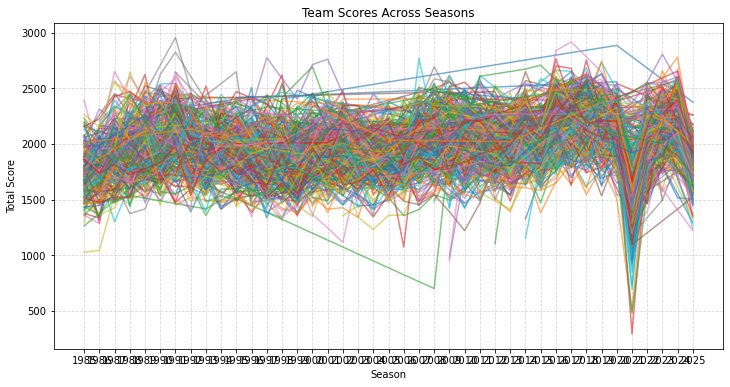

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort data by Season and TeamID
TeamsInRegularSeasonNotInTourney_totals = TeamsInRegularSeasonNotInTourney_totals.sort_values(['TeamID', 'Season'])

# Create the plot
plt.figure(figsize=(12, 6))

# Plot one line per TeamID
for team_id, team_data in TeamsInRegularSeasonNotInTourney_totals.groupby('TeamID'):
    plt.plot(team_data['Season'], team_data['Score'], label=team_id, alpha=0.6)

# Labels and title
plt.xlabel("Season")
plt.ylabel("Total Score")
plt.title("Team Scores Across Seasons")
plt.xticks(sorted(TeamsInRegularSeasonNotInTourney_totals['Season'].unique()))  # Ensure chronological order
plt.grid(True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()

### Wchich Teams did make it to the tournament?

In [47]:
tourney_teams = MNCAATourneySeeds[['Season', 'TeamID']].drop_duplicates()

# Create a DataFrame with scores when teams won
win_scores = MRegularSeasonCompactResults[['Season', 'WTeamID', 'WScore']].rename(
    columns={'WTeamID': 'TeamID', 'WScore': 'Score'}
)

# Create a DataFrame with scores when teams lost
loss_scores = MRegularSeasonCompactResults[['Season', 'LTeamID', 'LScore']].rename(
    columns={'LTeamID': 'TeamID', 'LScore': 'Score'}
)

# Concatenate the two DataFrames to have one row per team per game
all_scores = pd.concat([win_scores, loss_scores], ignore_index=True)

# Group by Season and TeamID to calculate the total score for each team per season
total_scores = all_scores.groupby(['Season', 'TeamID'])['Score'].sum().reset_index()
mean_scores = all_scores.groupby(['Season', 'TeamID'])['Score'].mean().reset_index()
score_stats = pd.merge(total_scores, mean_scores, on=['Season', 'TeamID'], suffixes=('', '_Mean'))

# Filter for teams that are in TeamsInRegularSeasonNotInTourney
TeamsInRegularSeasonInTourney_totals = pd.merge(
    tourney_teams,
    score_stats,
    on=['Season', 'TeamID'],
    how='left'
)

import matplotlib.pyplot as plt
import seaborn as sns

# Sort data by Season and TeamID
TeamsInRegularSeasonNotInTourney_totals = TeamsInRegularSeasonNotInTourney_totals.sort_values(['TeamID', 'Season'])

year = 2010
print('For year ', year)
# In case a team has no score (shouldn't happen if they played), fill with 0
TeamsInRegularSeasonInTourney_totals['Score'] = TeamsInRegularSeasonInTourney_totals['Score'].fillna(0)
print('Min score of team, that did make it into tourney: ',
      min(TeamsInRegularSeasonInTourney_totals['Score'][TeamsInRegularSeasonInTourney_totals['Season']==year]))
print('Max score of team, that did make it into tourney: ',
      max(TeamsInRegularSeasonInTourney_totals['Score'][TeamsInRegularSeasonInTourney_totals['Season']==year]))
print('Min mean score of team, that did make it into tourney: ',
      min(TeamsInRegularSeasonInTourney_totals['Score_Mean'][TeamsInRegularSeasonInTourney_totals['Season']==year]))
TeamsInRegularSeasonInTourney_totals.head()

For year  2010
Min score of team, that did make it into tourney:  1877
Max score of team, that did make it into tourney:  2780
Min mean score of team, that did make it into tourney:  62.56666666666667


,Season,TeamID,Score,Score_Mean
0,1985,1207,2045,75.740741
1,1985,1210,2198,70.903226
2,1985,1228,2115,68.225806
3,1985,1260,2575,85.833333
4,1985,1374,2279,75.966667


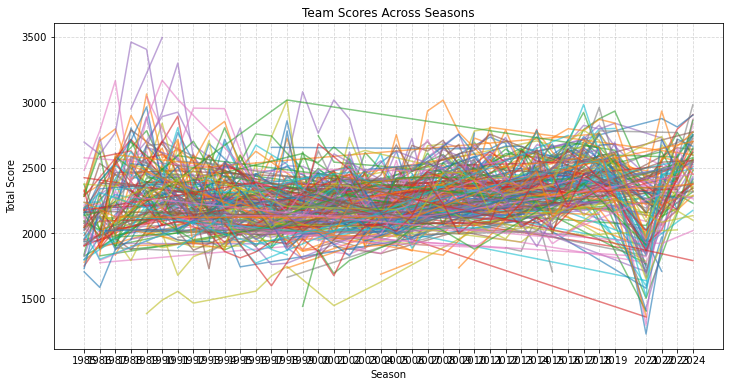

In [48]:
# Create the plot
plt.figure(figsize=(12, 6))
# Plot one line per TeamID
for team_id, team_data in TeamsInRegularSeasonInTourney_totals.groupby('TeamID'):
    plt.plot(team_data['Season'], team_data['Score'], label=team_id, alpha=0.6)
# Labels and title
plt.xlabel("Season")
plt.ylabel("Total Score")
plt.title("Team Scores Across Seasons")
plt.xticks(sorted(TeamsInRegularSeasonInTourney_totals['Season'].unique()))  # Ensure chronological order
plt.grid(True, linestyle="--", alpha=0.5)
# Show the plot
plt.show()

There is no clear score boundary from whitch teams are qualified into the tournament. The teams, who qualify then to have larger score on average though. The mechanism for accepting teams during selection sunday aren't known, or at least I haven't found much, but other than the score from regular season conferences should influence this decision.

### Seed impact on winning

In [38]:
merged_results = pd.merge(
    MNCAATourneyCompactResults,
    MNCAATourneySeeds[['Season', 'Seed', 'TeamID']],
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID'],
    how='left'
).rename(columns={'Seed': 'WTeamSeed'}).drop('TeamID', axis=1)

# Merge to get the losing team's seed
TourneySeedResults = pd.merge(
    merged_results,
    MNCAATourneySeeds[['Season', 'Seed', 'TeamID']],
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID'],
    how='left'
).rename(columns={'Seed': 'LTeamSeed'}).drop('TeamID', axis=1)

TourneySeedResults['WTeamSeedRaw'] = TourneySeedResults['WTeamSeed'].str.extract('(\d+)')[0].astype(int)
TourneySeedResults['LTeamSeedRaw'] = TourneySeedResults['LTeamSeed'].str.extract('(\d+)')[0].astype(int)

# Extract the letter prefix from WTeamSeed and LTeamSeed
TourneySeedResults['WTeamSeedPrefix'] = TourneySeedResults['WTeamSeed'].str[0]  # First character
TourneySeedResults['LTeamSeedPrefix'] = TourneySeedResults['LTeamSeed'].str[0]  # First character

# Extract the letter prefix from WTeamSeed and LTeamSeed (useful for looking for play-ins)
TourneySeedResults['WTeamSeedSufix'] = TourneySeedResults['WTeamSeed'].str[-1]  # Last character
TourneySeedResults['LTeamSeedSufix'] = TourneySeedResults['LTeamSeed'].str[-1]  # Last character

TourneySeedResults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WTeamSeed,LTeamSeed,WTeamSeedRaw,LTeamSeedRaw,WTeamSeedPrefix,LTeamSeedPrefix,WTeamSeedSufix,LTeamSeedSufix
0,1985,136,1116,63,1234,54,N,0,X09,X08,9,8,X,X,9,8
1,1985,136,1120,59,1345,58,N,0,Z11,Z06,11,6,Z,Z,1,6
2,1985,136,1207,68,1250,43,N,0,W01,W16,1,16,W,W,1,6
3,1985,136,1229,58,1425,55,N,0,Y09,Y08,9,8,Y,Y,9,8
4,1985,136,1242,49,1325,38,N,0,Z03,Z14,3,14,Z,Z,3,4


In tournament win count based on seed


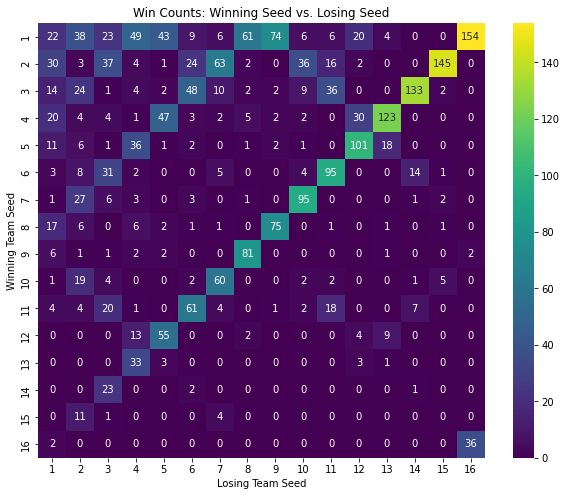

In [41]:
# Create the 16x16 matrix with seed values from 1 to 16
seed_matrix_all = pd.crosstab(TourneySeedResults['WTeamSeedRaw'], TourneySeedResults['LTeamSeedRaw'])
seeds = range(1, 17)
seed_matrix_all = seed_matrix_all.reindex(index=seeds, columns=seeds, fill_value=0)

# If you are in a Jupyter Notebook, simply display the styled DataFrame:
print("In tournament win count based on seed")

# Plot a heatmap with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(seed_matrix_all, annot=True, fmt='d', cmap='viridis')
plt.title('Win Counts: Winning Seed vs. Losing Seed')
plt.xlabel('Losing Team Seed')
plt.ylabel('Winning Team Seed')
plt.show()

In tournament win count based on seed counted internally in region
Note: the diagonal entries are play-ins


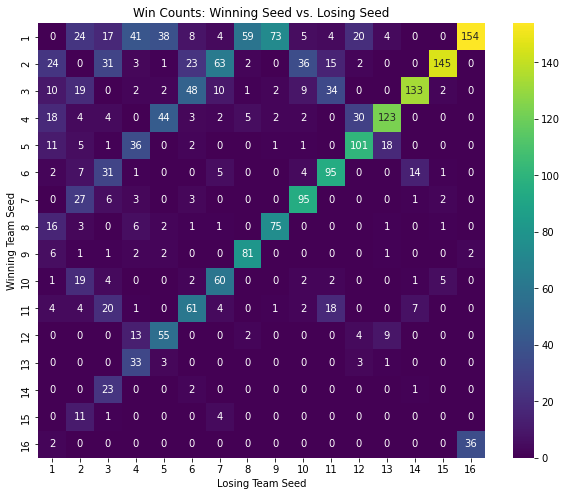

In [42]:
# Filter rows where WTeamSeed and LTeamSeed have different prefixes
filtered_results = TourneySeedResults[TourneySeedResults['WTeamSeedPrefix'] == TourneySeedResults['LTeamSeedPrefix']]

# Create the 16x16 matrix based on the filtered results
seed_matrix_region = pd.crosstab(filtered_results['WTeamSeedRaw'], filtered_results['LTeamSeedRaw'])

# Ensure the matrix includes all seeds from 1 to 16
seeds = range(1, 17)
seed_matrix_region = seed_matrix_region.reindex(index=seeds, columns=seeds, fill_value=0)

print("In tournament win count based on seed counted internally in region")
print("Note: the diagonal entries are play-ins")

# Plot a heatmap with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(seed_matrix_region, annot=True, fmt='d', cmap='viridis')
plt.title('Win Counts: Winning Seed vs. Losing Seed')
plt.xlabel('Losing Team Seed')
plt.ylabel('Winning Team Seed')
plt.show()

In-tournament win count based on seed vs teams from other region
(so only the teams that got to the Final Four stage)


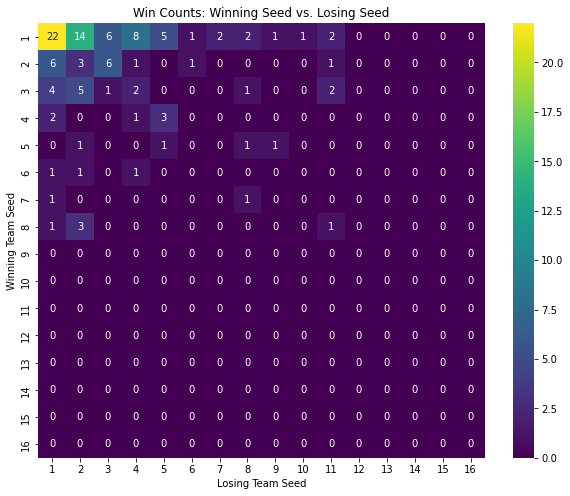

In [45]:
seed_matrix_external = seed_matrix_all - seed_matrix_region

# If you are in a Jupyter Notebook, simply display the styled DataFrame:
print("In-tournament win count based on seed vs teams from other region")
print("(so only the teams that got to the Final Four stage)")

# Plot a heatmap with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(seed_matrix_external, annot=True, fmt='d', cmap='viridis')
plt.title('Win Counts: Winning Seed vs. Losing Seed')
plt.xlabel('Losing Team Seed')
plt.ylabel('Winning Team Seed')
plt.show()

Lower seeds (1 especially) get to the championship games (out of region).

Scores from tournament


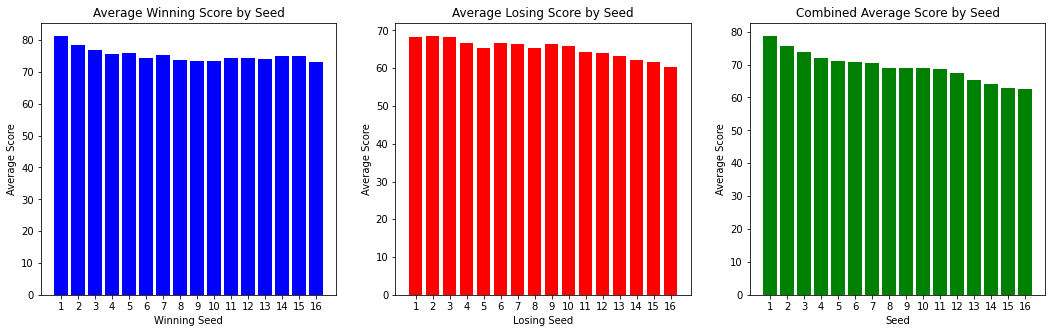

In [15]:
# Compute average score for winning teams grouped by winning seed
avg_win = TourneySeedResults.groupby('WTeamSeedRaw')['WScore'].mean().sort_index()

# Compute average score for losing teams grouped by losing seed
avg_loss = TourneySeedResults.groupby('LTeamSeedRaw')['LScore'].mean().sort_index()

# For combined average: combine winning and losing scores into one dataframe.
winning_scores = TourneySeedResults[['WTeamSeedRaw', 'WScore']].rename(columns={'WTeamSeedRaw':'Seed', 'WScore':'Score'})
losing_scores  = TourneySeedResults[['LTeamSeedRaw', 'LScore']].rename(columns={'LTeamSeedRaw':'Seed', 'LScore':'Score'})
combined_scores = pd.concat([winning_scores, losing_scores], ignore_index=True)

avg_combined = combined_scores.groupby('Seed')['Score'].mean().sort_index()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Winning seeds only
axes[0].bar(avg_win.index, avg_win.values, color='blue')
axes[0].set_title('Average Winning Score by Seed')
axes[0].set_xlabel('Winning Seed')
axes[0].set_ylabel('Average Score')
axes[0].set_xticks(range(1, 17))

# Plot 2: Losing seeds only
axes[1].bar(avg_loss.index, avg_loss.values, color='red')
axes[1].set_title('Average Losing Score by Seed')
axes[1].set_xlabel('Losing Seed')
axes[1].set_ylabel('Average Score')
axes[1].set_xticks(range(1, 17))

# Plot 3: Combined seeds (winning + losing)
axes[2].bar(avg_combined.index, avg_combined.values, color='green')
axes[2].set_title('Combined Average Score by Seed')
axes[2].set_xlabel('Seed')
axes[2].set_ylabel('Average Score')
axes[2].set_xticks(range(1, 17))

print("Scores from tournament")
plt.show()

In [31]:
TourneySeedResults[TourneySeedResults['DayNum'] == 154].groupby('WTeamSeedRaw').size().reset_index(name='count')
# 154 is always the final day

,WTeamSeedRaw,count
0,1,25
1,2,5
2,3,4
3,4,2
4,6,1
5,7,1
6,8,1


So historically only the 8 best seeds have ever won and the lower seeds are very favoured in matchmaking.

### Team vs team win fraction

Performance in Tourney


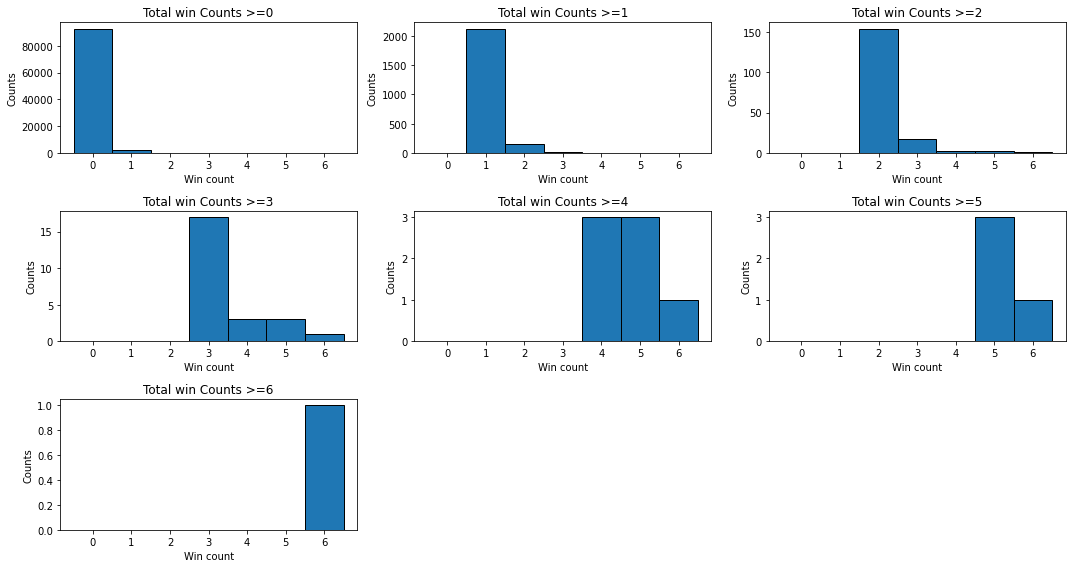

In [117]:
print('Performance in Tourney')

MTeamVsTeamWinCount = MNCAATourneyCompactResults.groupby(['WTeamID', 'LTeamID']).size().reset_index(name='count')
MTeamVsTeamWinCount = MTeamVsTeamWinCount.sort_values(by=['WTeamID', 'LTeamID'])

teams = pd.unique(MTeamVsTeamWinCount[['WTeamID', 'LTeamID']].values.ravel())
all_matchups = pd.DataFrame(itertools.product(teams, teams), columns=['WTeamID', 'LTeamID'])
all_matchups = all_matchups[all_matchups['WTeamID'] != all_matchups['LTeamID']]

MTeamVsTeamWinCount = all_matchups.merge(MTeamVsTeamWinCount, on=['WTeamID', 'LTeamID'], how='left').fillna(0)
MTeamVsTeamWinCount['count'] = MTeamVsTeamWinCount['count'].astype(int)
max_win_count = max(MTeamVsTeamWinCount['count'])

plt.figure(figsize=(15, 8))
for i in range(max_win_count + 1):
    tmp = MTeamVsTeamWinCount[MTeamVsTeamWinCount['count'] >= i]
    plt.subplot(math.ceil(max_win_count / 2),
                math.floor(max_win_count / 2 - 1) + 1,
                i + 1)
    bins = np.arange(max_win_count + 2) - 0.5 
    hist_values, bin_edges, _ = plt.hist(tmp['count'], bins=bins, edgecolor='black')
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.xticks(bin_centers, labels=[f"{x:.0f}" for x in bin_centers])
    plt.xlabel('Win count')
    plt.ylabel('Counts')
    plt.title(f'Total win Counts >={i}')

plt.tight_layout()
plt.show()

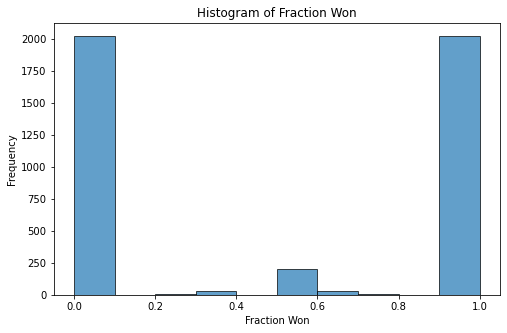

In [119]:
MTeamVsTeamWinCount["TeamPair"] = MTeamVsTeamWinCount.apply(lambda row: tuple(sorted([row["WTeamID"], row["LTeamID"]])), axis=1)

# Aggregate the total games played for each team pair
MTeamVsTeamWinCount["TotalGames"] = MTeamVsTeamWinCount.groupby("TeamPair")["count"].transform("sum")

# Drop the temporary TeamPair column if not needed
MTeamVsTeamWinCount = MTeamVsTeamWinCount.drop(columns=["TeamPair"])

MTeamVsTeamWinCount["FractionWon"] = MTeamVsTeamWinCount["count"] / MTeamVsTeamWinCount["TotalGames"]

MTeamVsTeamWinFraction = MTeamVsTeamWinCount[MTeamVsTeamWinCount["TotalGames"] > 0]

plt.figure(figsize=(8, 5))
plt.hist(MTeamVsTeamWinFraction["FractionWon"], bins=10, edgecolor='black', alpha=0.7)

# Labeling
plt.xlabel("Fraction Won")
plt.ylabel("Frequency")
plt.title("Histogram of Fraction Won")

# Show the plot
plt.show()

Performance in Regular Season
Max win count:  84


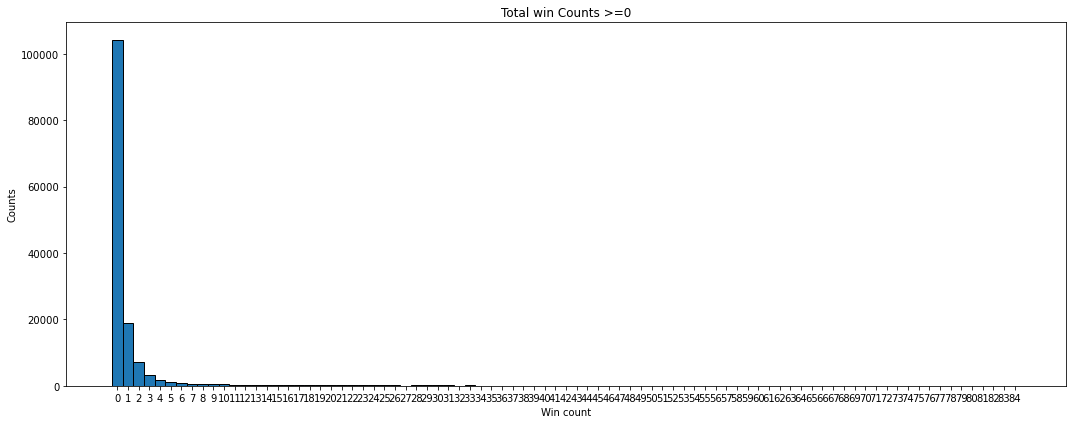

In [120]:
print('Performance in Regular Season')

MTeamVsTeamWinCount = MRegularSeasonCompactResults.groupby(['WTeamID', 'LTeamID']).size().reset_index(name='count')
MTeamVsTeamWinCount = MTeamVsTeamWinCount.sort_values(by=['WTeamID', 'LTeamID'])

teams = pd.unique(MTeamVsTeamWinCount[['WTeamID', 'LTeamID']].values.ravel())
all_matchups = pd.DataFrame(itertools.product(teams, teams), columns=['WTeamID', 'LTeamID'])
all_matchups = all_matchups[all_matchups['WTeamID'] != all_matchups['LTeamID']]

MTeamVsTeamWinCount = all_matchups.merge(MTeamVsTeamWinCount, on=['WTeamID', 'LTeamID'], how='left').fillna(0)
MTeamVsTeamWinCount['count'] = MTeamVsTeamWinCount['count'].astype(int)

max_win_count = max(MTeamVsTeamWinCount['count'])
print('Max win count: ', max_win_count)

# **Fix: Use plt.subplots()**
fig, axes = plt.subplots(1, 1, figsize=(15, 6))  # 1 row, 2 columns

tmp = MTeamVsTeamWinCount[MTeamVsTeamWinCount['count'] >= 0]
bins = np.arange(max_win_count + 2) - 0.5 
hist_values, bin_edges, _ = plt.hist(tmp['count'], bins=bins, edgecolor='black')
    
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.xticks(bin_centers, labels=[f"{x:.0f}" for x in bin_centers])

plt.xlabel('Win count')
plt.ylabel('Counts')
plt.title(f'Total win Counts >={0}')

plt.tight_layout()
plt.show()

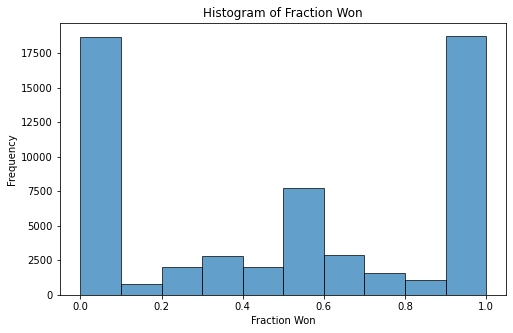

In [121]:
MTeamVsTeamWinCount["TeamPair"] = MTeamVsTeamWinCount.apply(lambda row: tuple(sorted([row["WTeamID"], row["LTeamID"]])), axis=1)

# Aggregate the total games played for each team pair
MTeamVsTeamWinCount["TotalGames"] = MTeamVsTeamWinCount.groupby("TeamPair")["count"].transform("sum")

# Drop the temporary TeamPair column if not needed
MTeamVsTeamWinCount = MTeamVsTeamWinCount.drop(columns=["TeamPair"])

MTeamVsTeamWinCount["FractionWon"] = MTeamVsTeamWinCount["count"] / MTeamVsTeamWinCount["TotalGames"]

MTeamVsTeamWinFraction = MTeamVsTeamWinCount[MTeamVsTeamWinCount["TotalGames"] > 0]

plt.figure(figsize=(8, 5))
plt.hist(MTeamVsTeamWinFraction["FractionWon"], bins=10, edgecolor='black', alpha=0.7)

# Labeling
plt.xlabel("Fraction Won")
plt.ylabel("Frequency")
plt.title("Histogram of Fraction Won")

# Show the plot
plt.show()

### How teams IDs are given

In [23]:
df = MTeams
print("Team IDs")
print('max number:', max(df['TeamID']))
print('min number:', min(df['TeamID']))
print('missng team numbers from sequence: ', sorted(set(range(min(df['TeamID']), max(df['TeamID'])+1)) - set(df['TeamID'])))

Team IDs
max number: 1480
min number: 1101
missng team numbers:  []


### How consistent are certain teams

In [5]:
df = MRegularSeasonDetailedResults

# --- Step 1. Identify the extra columns (from 'NumOT' onward) ---
cols = df.columns.tolist()
start_index = cols.index('NumOT')
extra_columns = cols[start_index:]
# extra_columns now holds the list of columns for which we want the mean

# --- Step 2. Aggregate winning and losing records separately ---

# For wins: group by Season and winning team (WTeamID)
wins_agg = df.groupby(['Season', 'WTeamID']).agg(
    wins_count=('WTeamID', 'size'),
    mean_winning_score=('WScore', 'mean')
).reset_index().rename(columns={'WTeamID': 'TeamID'})

# For losses: group by Season and losing team (LTeamID)
losses_agg = df.groupby(['Season', 'LTeamID']).agg(
    losses_count=('LTeamID', 'size'),
    mean_losing_score=('LScore', 'mean')
).reset_index().rename(columns={'LTeamID': 'TeamID'})

# --- Step 3. Overall game-level aggregation for the extra columns and overall mean score ---
# Create two dataframes—one for wins and one for losses—with the extra columns.
wins_extra = df[['Season', 'WTeamID'] + extra_columns].rename(columns={'WTeamID': 'TeamID'})
losses_extra = df[['Season', 'LTeamID'] + extra_columns].rename(columns={'LTeamID': 'TeamID'})

# Combine both so that each game appears once per team
all_extra = pd.concat([wins_extra, losses_extra], ignore_index=True)
overall_extra = all_extra.groupby(['Season', 'TeamID']).mean().reset_index()

# For the overall score, combine the scores from wins and losses.
wins_score = df[['Season', 'WTeamID', 'WScore']].rename(
    columns={'WTeamID': 'TeamID', 'WScore': 'Score'}
)
losses_score = df[['Season', 'LTeamID', 'LScore']].rename(
    columns={'LTeamID': 'TeamID', 'LScore': 'Score'}
)
all_scores = pd.concat([wins_score, losses_score], ignore_index=True)
overall_scores = all_scores.groupby(['Season', 'TeamID']).agg(
    total_score_sum=('Score', 'sum'),
    total_games=('Score', 'size')
).reset_index()
overall_scores['mean_score'] = overall_scores['total_score_sum'] / overall_scores['total_games']

# --- Step 4. Merge the wins and losses aggregates ---
agg = pd.merge(wins_agg, losses_agg, on=['Season', 'TeamID'], how='outer')

# Fill missing win/loss counts with 0 (teams that only lost or only won)
agg['wins_count'] = agg['wins_count'].fillna(0)
agg['losses_count'] = agg['losses_count'].fillna(0)
agg['total_games'] = agg['wins_count'] + agg['losses_count']

# Compute fractions for wins and losses
agg['fraction_wins'] = agg['wins_count'] / agg['total_games']
agg['fraction_losses'] = agg['losses_count'] / agg['total_games']

# --- Step 5. Merge overall score and extra columns ---
agg = pd.merge(agg, overall_scores[['Season', 'TeamID', 'mean_score']], on=['Season', 'TeamID'], how='outer')
final_df = pd.merge(agg, overall_extra, on=['Season', 'TeamID'], how='outer')

# --- Step 6. Rearrange columns in the desired order ---
final_df = final_df[['Season', 'TeamID', 'fraction_wins', 'fraction_losses', 
                     'mean_winning_score', 'mean_losing_score', 'mean_score'] + extra_columns]

print('fraction of wins / losses, means of other parameters')
# Display the resulting dataframe
final_df.head()

fraction of wins / losses, means of other parameters


,Season,TeamID,fraction_wins,fraction_losses,mean_winning_score,mean_losing_score,mean_score,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,1102,0.428571,0.571429,68.750000,48.625000,57.250000,0.000000,20.821429,39.571429,...,17.642857,9.785714,14.428571,7.071429,16.250000,9.035714,12.750000,5.357143,0.964286,20.535714
1,2003,1103,0.481481,0.518519,87.769231,70.428571,78.777778,0.296296,28.962963,54.777778,...,18.962963,16.444444,22.148148,11.703704,19.259259,13.296296,14.296296,6.851852,2.629630,22.074074
2,2003,1104,0.607143,0.392857,74.705882,60.909091,69.285714,0.035714,25.500000,56.000000,...,19.178571,11.928571,16.821429,12.178571,21.785714,10.178571,14.535714,5.357143,2.785714,20.321429
3,2003,1105,0.269231,0.730769,79.428571,68.947368,71.769231,0.153846,27.692308,60.115385,...,19.423077,14.576923,21.269231,13.115385,22.500000,13.615385,19.730769,8.192308,2.615385,20.384615
4,2003,1106,0.464286,0.535714,68.307692,59.533333,63.607143,0.035714,24.500000,53.321429,...,16.750000,12.250000,17.607143,11.678571,19.964286,9.928571,16.214286,8.035714,2.535714,18.071429


In [7]:
# Step 1: Identify extra columns starting from 'NumOT'
cols = MRegularSeasonCompactResults.columns.tolist()
start_index = cols.index('NumOT')
extra_columns = cols[start_index:]

# Step 2: Create a long-form DataFrame from raw game data for wins and losses
wins_df = MRegularSeasonCompactResults[['Season', 'WTeamID', 'WScore'] + extra_columns].copy()
wins_df = wins_df.rename(columns={'WTeamID': 'TeamID', 'WScore': 'Score'})
wins_df['win_flag'] = 1

losses_df = MRegularSeasonCompactResults[['Season', 'LTeamID', 'LScore'] + extra_columns].copy()
losses_df = losses_df.rename(columns={'LTeamID': 'TeamID', 'LScore': 'Score'})
losses_df['win_flag'] = 0

# Concatenate wins and losses into a single DataFrame
long_df = pd.concat([wins_df, losses_df], ignore_index=True)

# Step 3: Compute standard deviation on raw game data for each team (ignoring Season)

# Overall standard deviation of the score (from all games)
std_total_score = long_df.groupby('TeamID')['Score'].std().reset_index().rename(columns={'Score': 'std_total_score'})

# Standard deviation of win indicator (binary: 1 for win, 0 for loss)
std_win_flag = long_df.groupby('TeamID')['win_flag'].std().reset_index().rename(columns={'win_flag': 'std_win_flag'})

# Standard deviation of winning scores (only on wins)
std_winning_score = wins_df.groupby('TeamID')['Score'].std().reset_index().rename(columns={'Score': 'std_winning_score'})

# Standard deviation of losing scores (only on losses)
std_losing_score = losses_df.groupby('TeamID')['Score'].std().reset_index().rename(columns={'Score': 'std_losing_score'})

# Standard deviations for the extra columns (from 'NumOT' onward) across all games
std_extra = long_df.groupby('TeamID')[extra_columns].std().reset_index()

# Merge all standard deviation calculations on TeamID (ignoring Season)
raw_std_in_seasonstd_df = std_total_score.merge(std_win_flag, on='TeamID', how='outer') \
    .merge(std_winning_score, on='TeamID', how='outer') \
    .merge(std_losing_score, on='TeamID', how='outer') \
    .merge(std_extra, on='TeamID', how='outer')

print('std of raw values')
# raw_std_df now contains TeamID and the standard deviations of the raw data metrics.
raw_std_in_seasonstd_df.head()

std of raw values


,TeamID,std_total_score,std_win_flag,std_winning_score,std_losing_score,NumOT
0,1101,11.931218,0.499884,8.113678,11.495789,0.320089
1,1102,12.136450,0.479471,11.850982,10.335667,0.243537
2,1103,12.291633,0.492515,10.857103,10.825376,0.266008
3,1104,13.056490,0.482602,12.450349,10.200421,0.285332
4,1105,12.391173,0.476859,11.048283,10.594939,0.328072


In [9]:
# Group by TeamID and compute standard deviation (ignoring Season)
std_mean_season = final_df.groupby('TeamID').std().reset_index()

# Rename the columns to indicate standard deviation
std_mean_season = std_mean_season.rename(columns={col: f"{col}_std" for col in std_mean_season.columns if col != 'TeamID'})

print("std of the mean per season, std of fraction of wins / losses")
std_mean_season.head()

std of the mean per season, std of fraction of wins / losses


,TeamID,Season_std,fraction_wins_std,fraction_losses_std,mean_winning_score_std,mean_losing_score_std,mean_score_std,NumOT_std,WFGM_std,WFGA_std,...,LFGA3_std,LFTM_std,LFTA_std,LOR_std,LDR_std,LAst_std,LTO_std,LStl_std,LBlk_std,LPF_std
0,1101,3.605551,0.217339,0.217339,1.914375,3.406443,4.291418,0.060886,0.643919,2.249740,...,1.580100,2.048921,2.401151,0.797662,1.578799,1.156071,1.919112,0.903986,0.655485,1.100463
1,1102,6.782330,0.171020,0.171020,5.345238,5.488994,4.765477,0.040691,2.296467,5.015475,...,2.573523,1.290292,1.943482,1.295292,2.412251,1.441913,1.059460,0.520334,0.585501,1.156608
2,1103,6.782330,0.108017,0.108017,4.423857,3.716268,3.960763,0.068028,1.690424,2.763002,...,2.827639,1.471371,1.797817,1.754076,1.630498,1.284712,1.578124,0.776327,0.349569,1.195069
3,1104,6.782330,0.111773,0.111773,7.842676,5.992397,7.612614,0.048904,2.434801,4.189885,...,3.354974,1.752719,2.295525,1.261851,1.282855,1.108919,1.170794,0.887826,0.541961,1.262122
4,1105,6.782330,0.120680,0.120680,4.724295,4.306932,4.220983,0.051831,1.501945,2.423329,...,2.020248,2.066282,2.869323,1.792859,1.535935,1.150972,2.135773,1.366206,1.040784,1.605426


### How many years back are results consistent

C:\Users\Sebastian\anaconda3\lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\Sebastian\anaconda3\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


Average autocorrelation for 'fraction_wins' by lag:
Lag 1: 0.280
Lag 2: 0.098
Lag 3: -0.022
Lag 4: -0.035
Lag 5: -0.035


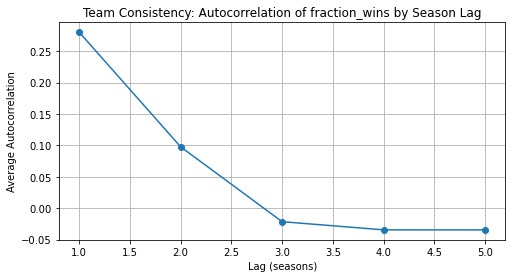

Based on a threshold of 0.2, results are consistent up to 1 season(s) back.


In [12]:
def compute_autocorrelations(df, metric, max_lag):
    """
    Compute the average autocorrelation for a given metric over different lags.
    
    Parameters:
        df (DataFrame): DataFrame with season-level team data.
        metric (str): The column name to compute autocorrelation on.
        max_lag (int): Maximum lag (in seasons) to compute.
        
    Returns:
        dict: Dictionary mapping lag -> average autocorrelation (across teams).
    """
    autocorr_by_lag = {}
    teams = df['TeamID'].unique()
    for lag in range(1, max_lag+1):
        ac_list = []
        for team in teams:
            team_data = df[df['TeamID'] == team].sort_values('Season')
            if len(team_data) > lag:
                ac = team_data[metric].autocorr(lag=lag)
                if not np.isnan(ac):
                    ac_list.append(ac)
        # Average the autocorrelations for this lag across teams
        autocorr_by_lag[lag] = np.mean(ac_list) if ac_list else np.nan
    return autocorr_by_lag

df = final_df # from 1st cell previous section

# Determine the maximum lag to consider: e.g. the smallest maximum number of seasons available among teams or a fixed number.
max_possible_lag = df.groupby('TeamID')['Season'].count().max() - 1
max_lag = min(5, max_possible_lag) if max_possible_lag >= 1 else 1

# Compute average autocorrelations for the 'fraction_wins' metric.
avg_ac = compute_autocorrelations(df, 'fraction_wins', max_lag)

print("Average autocorrelation for 'fraction_wins' by lag:")
for lag, ac in avg_ac.items():
    print(f"Lag {lag}: {ac:.3f}")

# Plot the average autocorrelation vs. lag.
lags = list(avg_ac.keys())
ac_values = list(avg_ac.values())

plt.figure(figsize=(8, 4))
plt.plot(lags, ac_values, marker='o')
plt.xlabel("Lag (seasons)")
plt.ylabel("Average Autocorrelation")
plt.title("Team Consistency: Autocorrelation of fraction_wins by Season Lag")
plt.grid(True)
plt.show()

# Determine up to how many seasons back results are consistent.
# For example, we can say results are consistent if the average autocorrelation is above a threshold.
threshold = 0.2
consistent_lags = [lag for lag, ac in avg_ac.items() if ac >= threshold]
max_consistent = max(consistent_lags) if consistent_lags else 0

print(f"Based on a threshold of {threshold}, results are consistent up to {max_consistent} season(s) back.")


Obviously the college teams change rapidly. The highest autocorrelation is one season back, no surprises here.